# Entrenamiento de modelos con series de tiempo Parte 1

**Proyecto Comercial Química**
Universidad de los Andes<br>
Ciencia de Datos Aplicada

Andrés Mauricio Martínez Celis &nbsp;  &nbsp; &nbsp;     202322624 <br>
Danilo Andrés Alfonso Bohórquez  &nbsp;      201611827 <br>
Jairo Vladimir Chaparro Rodríguez     201531080 <br>
Oscar Duvan Giraldo Romero  &nbsp; &nbsp;&nbsp; &nbsp;&nbsp;  202324939   <br>  


Last update: Noviembre, 2023

# MODELO ARIMA

In [1]:
#importanos libreriras para el modelado
import statsmodels.api as sm
from scipy import stats
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import LSTM
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
!pip install keras
!pip install tensorflow
from keras.preprocessing.sequence import TimeseriesGenerator
!pip install prophet
from prophet import Prophet

In [2]:
#Importamos el dataset que contiene la información de las ventas por producto en el periodo de tiempo comprendido entre 2020 y 2023
data = pd.read_csv("Archivos/arima.csv", delimiter=";", encoding="latin-1")


In [3]:
#Validamos nuestro datos
data.head()

,factura,fecha_contabilizacion,anio,mes,dia,nombre_cliente,nombre_empleado,articulo,lote,ciudad,...,proyecto,numero_articulo,importador,fh_vencimiento,fh_fabricacion,DescripcionLote,BG1,BGTR,BGRS,BGCS
0,36674,2020-09-25 00:00:00,2020,9,25,DUARTE RODRIGUEZ WILLIAM MOISES,JONATHAN ANDRES HERNANDEZ PRADA,CIPROFLOXACINA HCL,105-200424-2,BOGOTA,...,NaN,1007090000,CHINA,2024-04-23 00:00:00,2020-04-24 00:00:00,CIPROFLOXACINA HCL105-200424-2,1,1,0,0
1,36675,2020-09-25 00:00:00,2020,9,25,INVESAN SAS,JENNY MAGALY GONZALEZ FLOREZ,CIPROFLOXACINA HCL,105-200424-2,FLORIDABLANCA,...,NaN,1007090000,CHINA,2024-04-23 00:00:00,2020-04-24 00:00:00,CIPROFLOXACINA HCL105-200424-2,1,1,0,0
2,36031,2020-06-12 00:00:00,2020,6,12,COASPHARMA S.A.S.,JENNY MAGALY GONZALEZ FLOREZ,OXITETRACICLINA BASE INYECTABLE,TM191203024,BOGOTA,...,NaN,1007290000,CHINA,2022-12-23 00:00:00,2019-12-24 00:00:00,OXITETRACICLINA BASE INYECTABLETM191203024,1,1,0,0
3,36064,2020-06-18 00:00:00,2020,6,18,COLVET S.A.,JENNY MAGALY GONZALEZ FLOREZ,OXITETRACICLINA BASE INYECTABLE,TM191203024,BOGOTA,...,NaN,1007290000,CHINA,2022-12-23 00:00:00,2019-12-24 00:00:00,OXITETRACICLINA BASE INYECTABLETM191203024,1,1,0,0
4,36137,2020-07-01 00:00:00,2020,7,1,LABORATORIOS VETERLAND LTDA,JENNY MAGALY GONZALEZ FLOREZ,OXITETRACICLINA BASE INYECTABLE,TM191203024,BOGOTA,...,NaN,1007290000,CHINA,2022-12-23 00:00:00,2019-12-24 00:00:00,OXITETRACICLINA BASE INYECTABLETM191203024,1,1,0,0


In [4]:
#Verificamos la cantidad de información por cada una de las variables de nuestro dataset
data.count()

factura                  9158
fecha_contabilizacion    9158
anio                     9158
mes                      9158
dia                      9158
nombre_cliente           9158
nombre_empleado          9158
articulo                 9158
lote                     9158
ciudad                   9158
cantidad                 9158
precio_unitario          9158
total_lineas             9158
impuesto_total           9158
referencia_SN            9091
proyecto                    0
numero_articulo          9158
importador               9121
fh_vencimiento           9141
fh_fabricacion           9141
DescripcionLote          9158
BG1                      9158
BGTR                     9158
BGRS                     9158
BGCS                     9158
dtype: int64

In [5]:
# Convertir 'total_lineas' y 'cantidad' a valores numéricos y luego a enteros
data['total_lineas'] = pd.to_numeric(data['total_lineas'], errors='coerce').astype(int)
data['cantidad'] = pd.to_numeric(data['cantidad'], errors='coerce').astype(int)

# Verificar el tipo de datos
print(data.dtypes)


factura                    int64
fecha_contabilizacion     object
anio                       int64
mes                        int64
dia                        int64
nombre_cliente            object
nombre_empleado           object
articulo                  object
lote                      object
ciudad                    object
cantidad                   int32
precio_unitario            int64
total_lineas               int32
impuesto_total            object
referencia_SN             object
proyecto                 float64
numero_articulo            int64
importador                object
fh_vencimiento            object
fh_fabricacion            object
DescripcionLote           object
BG1                        int64
BGTR                       int64
BGRS                       int64
BGCS                       int64
dtype: object


In [6]:

# Nos aseguramos que 'fecha_contabilizacion' sea del tipo datetime
data['fecha_contabilizacion'] = pd.to_datetime(data['fecha_contabilizacion'])

# Generamos un DataFrame con todas las fechas desde el mínimo al máximo
min_fecha = data['fecha_contabilizacion'].min()
max_fecha = data['fecha_contabilizacion'].max()
fechas_completas = pd.date_range(start=min_fecha, end=max_fecha, freq='D')

# Crear un nuevo DataFrame con todas las fechas y unirlo con los datos originales
nuevo_data = pd.DataFrame({'fecha_contabilizacion': fechas_completas})
nuevo_data = nuevo_data.merge(data, on='fecha_contabilizacion', how='left')

# Agrupar por mes y calcular la media
mes_media = nuevo_data.groupby(nuevo_data['fecha_contabilizacion'].dt.to_period('M'))['total_lineas'].transform('mean')

# Llenar los valores faltantes de 'total_lineas' con la media del mes correspondiente si no es NaN
nuevo_data['total_lineas'] = nuevo_data['total_lineas'].combine_first(mes_media)

# Agrupar por día y calcular la suma de 'total_lineas'
resultados = nuevo_data.groupby(['fecha_contabilizacion'])['total_lineas'].sum().reset_index()

# Llenar los valores no finitos de 'cantidad' con 0
nuevo_data['cantidad'] = nuevo_data['cantidad'].fillna(0)

# Agrupar por día y calcular el promedio de 'cantidad'
resultados['cantidad'] = nuevo_data.groupby(['fecha_contabilizacion'])['cantidad'].mean().reset_index()['cantidad']

# Redondear el promedio de 'cantidad' a números enteros
resultados['cantidad'] = resultados['cantidad'].round().astype(int)

print(resultados)




     fecha_contabilizacion  total_lineas  cantidad
0               2020-02-03  1.000000e+01         1
1               2020-02-04  3.812047e+08        83
2               2020-02-05  4.702650e+08        68
3               2020-02-06  4.032125e+08        99
4               2020-02-07  6.355000e+07        83
...                    ...           ...       ...
1301            2023-08-27  1.549214e+07         0
1302            2023-08-28  6.960000e+06        54
1303            2023-08-29  6.107500e+07       217
1304            2023-08-30  7.300000e+06        25
1305            2023-08-31  4.250000e+06        25

[1306 rows x 3 columns]


In [7]:
#Verificamos nuesto dataframe resultante
resultados

,fecha_contabilizacion,total_lineas,cantidad
0,2020-02-03,1.000000e+01,1
1,2020-02-04,3.812047e+08,83
2,2020-02-05,4.702650e+08,68
3,2020-02-06,4.032125e+08,99
4,2020-02-07,6.355000e+07,83
...,...,...,...
1301,2023-08-27,1.549214e+07,0
1302,2023-08-28,6.960000e+06,54
1303,2023-08-29,6.107500e+07,217
1304,2023-08-30,7.300000e+06,25


In [8]:
# Realizar el test de estacionariedad para verificar que nuestra serie no sea estacional
result = adfuller(resultados['total_lineas'].dropna())
print(f"ADF static: {result[0]}")
print(f"p value: {result[1]}")
print(f"Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")


ADF static: -7.680288422969855
p value: 1.5102840187193005e-11
Lags Used: 22
Number of Observations Used: 1283


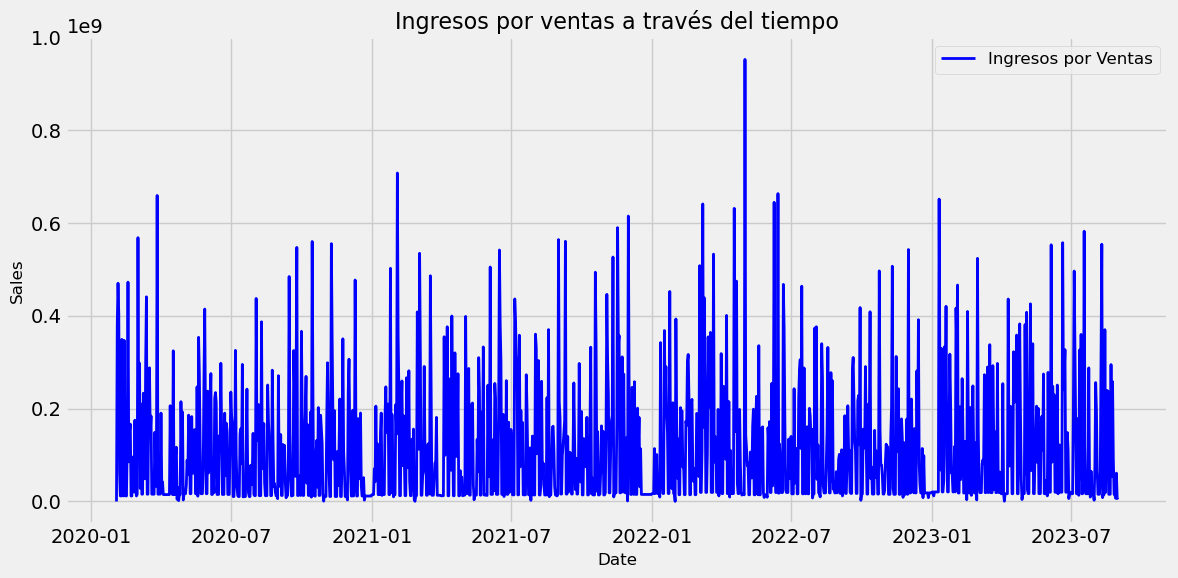

In [9]:
# Graficamos el numero de ventas a nivel diario para corroborar nuestro dataframe 
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha_contabilizacion'], resultados['total_lineas'], label='Ingresos por Ventas', color='blue', linewidth=2)
plt.title('Ingresos por ventas a través del tiempo', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
#Imprimimos el top 10 de los resultados con más ingresos por ventas con el fin de corroborar que no existan posibles outliers en la muestra
top_10_total_lineas = resultados.sort_values(by='total_lineas', ascending=False).head(10)
print(top_10_total_lineas)


     fecha_contabilizacion  total_lineas  cantidad
819             2022-05-02   952491000.0       234
366             2021-02-03   707744500.0       177
862             2022-06-14   663425000.0       462
53              2020-03-27   659365000.0       310
1072            2023-01-10   651564000.0       133
857             2022-06-09   644650000.0       363
764             2022-03-08   641086375.0       168
805             2022-04-18   631615000.0       285
667             2021-12-01   615033820.0        89
653             2021-11-17   590025000.0       216


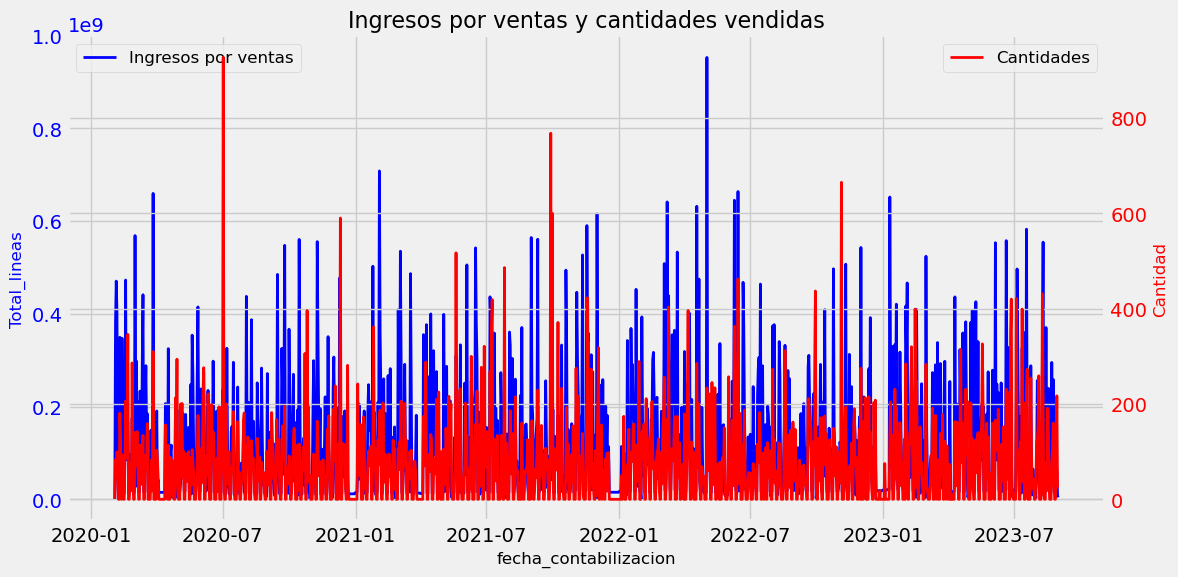

In [11]:
# En un solo gráfico plasmamos las ventas y las cantidades vendidas con el fin de validar la distribución
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Ingresos por ventas y cantidades vendidas', fontsize=16)
plt.xlabel('fecha_contabilizacion', fontsize=12)

# Ingresos por ventas
ax1.plot(resultados['fecha_contabilizacion'], resultados['total_lineas'], label='Ingresos por ventas', color='blue', linewidth=2)
ax1.set_ylabel('Total_lineas', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left', fontsize=12)

# Cantidades vendidas
ax2 = ax1.twinx()
ax2.plot(resultados['fecha_contabilizacion'], resultados['cantidad'], label='Cantidades', color='red', linewidth=2)
ax2.set_ylabel('Cantidad', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

Podemos observar que la distribución de las ventas es similar a la distribución de las cantidades vendidas, no obstante, en algunos días en específico, los valores son cero ya que son vacaciones colectivas empresariales. 

# Cálculo de la autocorrelación y Autocorrelación Parcial

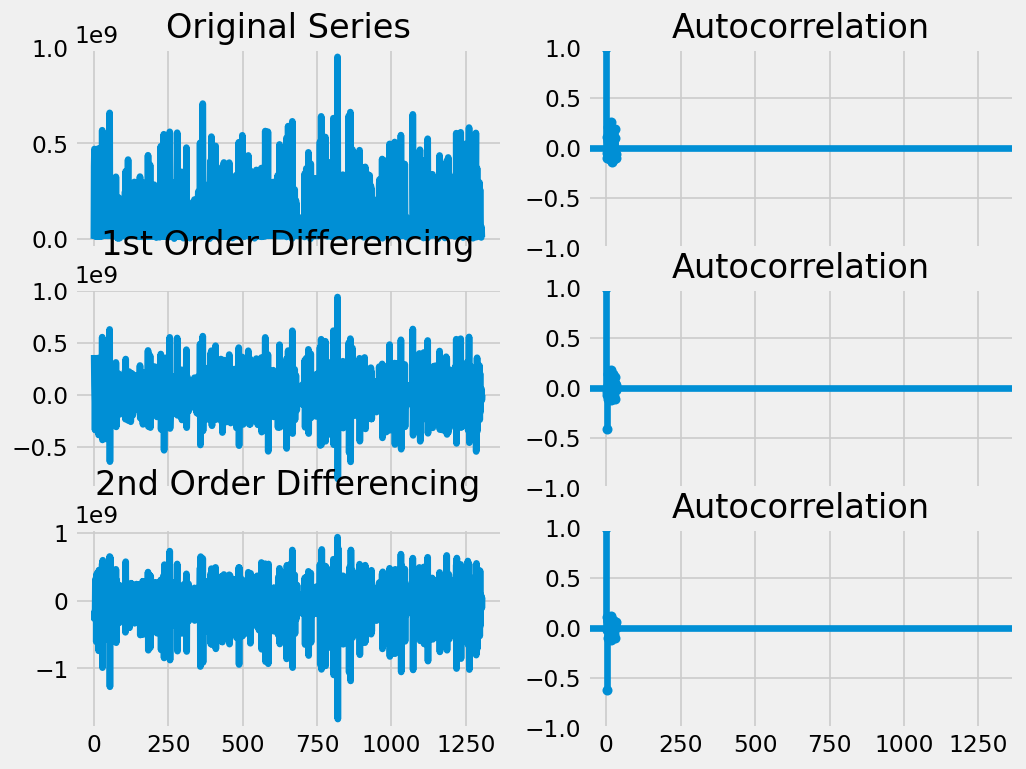

In [12]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(resultados.total_lineas); axes[0, 0].set_title('Original Series')
plot_acf(resultados.total_lineas, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(resultados.total_lineas.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(resultados.total_lineas.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(resultados.total_lineas.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(resultados.total_lineas.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

En este caso, la serie de tiempo original muestra una tendencia creciente. Después de la primera diferencia, la serie de tiempo se vuelve estacionaria. Esto significa que la media y la varianza de la serie de tiempo no cambian con el tiempo.

# Definición del Factor Autorregresivo AR

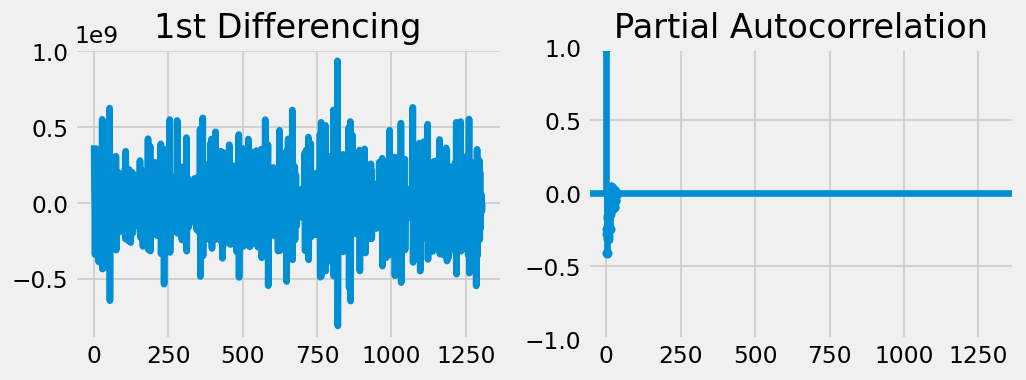

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(resultados.total_lineas.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(resultados.total_lineas.diff().dropna(), ax=axes[1])

plt.show()

Podemos observar que el retraso de PACF (Función de Autocorrelación Parcial) 1 es bastante significativo, ya que está claramente por encima de la línea de significancia. Por lo tanto, fijaremos el valor de p en 1.

# Definición del Promedio Móvil MA

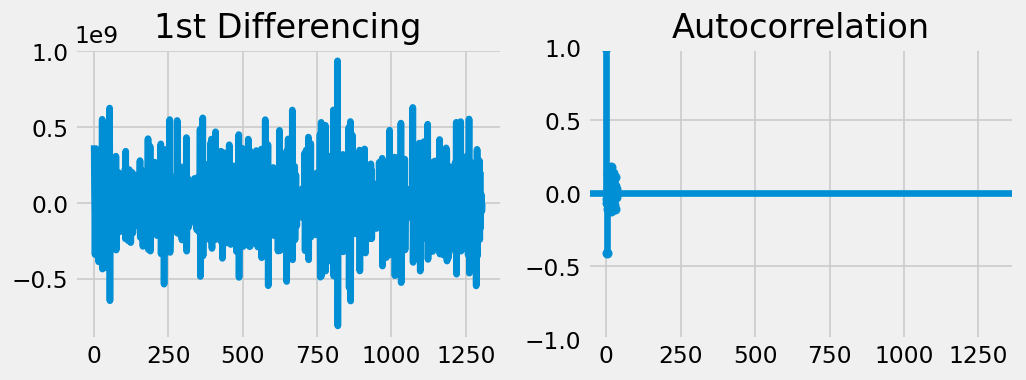

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(resultados.total_lineas.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(resultados.total_lineas.diff().dropna(), ax=axes[1])

plt.show()

# Calculamos la predicción del modelo ARIMA

In [15]:
# 1,1,2 ARIMA Model
model = ARIMA(resultados.total_lineas, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           total_lineas   No. Observations:                 1306
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -26266.487
Date:                Sun, 05 Nov 2023   AIC                          52540.975
Time:                        21:41:12   BIC                          52561.671
Sample:                             0   HQIC                         52548.739
                               - 1306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1140      0.280     -0.407      0.684      -0.664       0.436
ma.L1         -0.7655      0.278     -2.755      0.006      -1.310      -0.221
ma.L2         -0.2337      0.277     -0.844      0.3

**Modelo ARIMA(1,1,2)(1,1,2)[12]:**

- Componente Autorregresiva (AR): 1
- Componente de Diferenciación (I): 1
- Componente de Media Móvil (MA): 2
- Componente Autorregresiva Estacional (SAR): 1
- Componente de Diferenciación Estacional (SI): 1
- Componente de Media Móvil Estacional (SMA): 2
- Frecuencia Estacional (M): 12

Este modelo ARIMA se utiliza para modelar series de tiempo con una tendencia estacional que se repite cada 12 periodos. La componente AR(1) modela la relación de dependencia lineal con el valor anterior en la serie, la componente de diferenciación I(1) indica que se ha aplicado una diferenciación de primer orden para hacer que la serie sea estacionaria, y la componente MA(2) modela la dependencia lineal con los dos valores anteriores de los errores.

La parte estacional de este modelo ARIMA tiene una componente SAR(1) que modela la dependencia estacional con el valor de hace 12 periodos, una componente SI(1) para la diferenciación estacional de primer orden y una componente SMA(2) que modela la dependencia con los dos valores anteriores de los errores estacionales.

In [16]:
# 1,1,1 ARIMA Model
model = ARIMA(resultados.total_lineas, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           total_lineas   No. Observations:                 1306
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26283.039
Date:                Sun, 05 Nov 2023   AIC                          52572.079
Time:                        21:41:12   BIC                          52587.601
Sample:                             0   HQIC                         52577.901
                               - 1306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1119      0.038      2.963      0.003       0.038       0.186
ma.L1         -0.9990      0.008   -120.293      0.000      -1.015      -0.983
sigma2      2.279e+16   3.72e-20   6.13e+35      0.0

**Modelo ARIMA(1,1,2)(1,1,2)[12]:**

- Componente Autorregresiva (AR): 1
- Componente de Diferenciación (I): 1
- Componente de Media Móvil (MA): 2
- Componente Autorregresiva Estacional (SAR): 1
- Componente de Diferenciación Estacional (SI): 1
- Componente de Media Móvil Estacional (SMA): 2
- Frecuencia Estacional (M): 12


Este modelo ARIMA se utiliza para modelar series de tiempo con una tendencia estacional que se repite cada 12 periodos. Las componentes se definen de la siguiente manera:

- Componente AR(1): Modela la relación de dependencia lineal con el valor anterior en la serie.
- Componente de diferenciación I(1): Indica que se ha aplicado una diferenciación de primer orden para hacer que la serie sea estacionaria.
- Componente MA(2): Modela la dependencia lineal con los dos valores anteriores de los errores.

La parte estacional de este modelo ARIMA tiene las siguientes componentes:

- Componente SAR(1): Modela la dependencia estacional con el valor de hace 12 periodos.
- Componente SI(1): Indica una diferenciación estacional de primer orden.
- Componente SMA(2): Modela la dependencia con los dos valores anteriores de los errores estacionales.



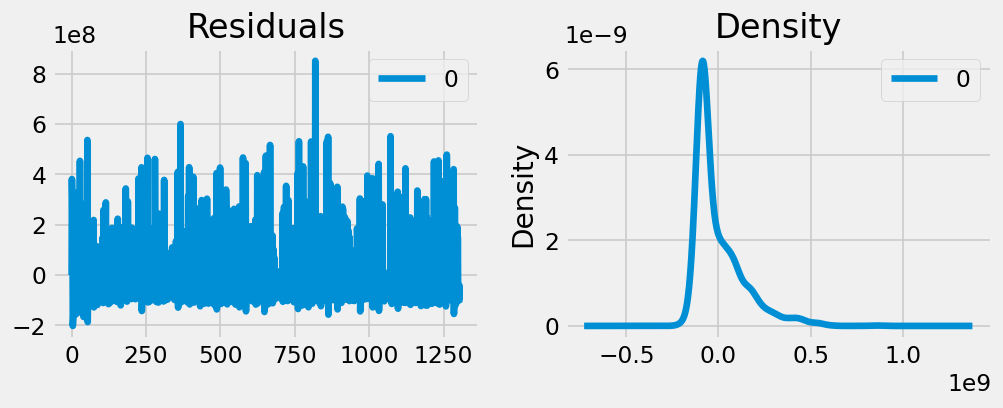

In [17]:
# Graficamos los residuales
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Podemos observar que no todos los residuales se comportan de manera homogenea y existen algunos que se alejan del 0, por lo que no existe un ajuste adecuado de dichos errores de acuerdo a lo pronosticado.

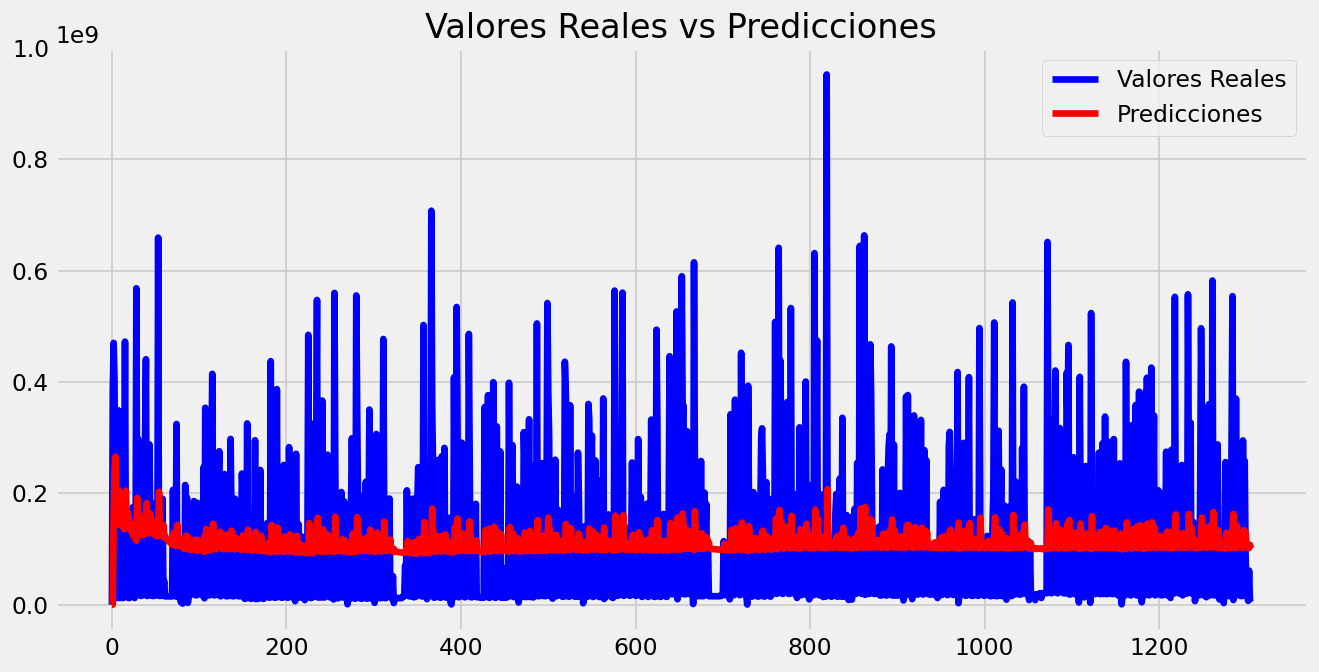

In [18]:
# Realizar una predicción
predictions = model_fit.predict(typ='levels')

# Graficar los valores reales y predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados.total_lineas, label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='red')
plt.legend()
plt.title('Valores Reales vs Predicciones')
plt.show()


**Conclusión:**

**Modelo 1:** El primer modelo, ARIMA(1, 1, 2), corresponde a un modelo ARIMA no estacional que se utiliza para modelar la parte no estacional de la serie de tiempo. En este modelo, se incluyen las componentes autorregresivas (AR), de diferenciación (I) y de media móvil (MA).

**Modelo 2:** El segundo modelo, ARIMA(1, 1, 2)(1, 1, 2)[12], es un modelo ARIMA estacional que se utiliza para modelar la parte estacional de la serie de tiempo. Este modelo incluye los mismos componentes AR, I y MA, pero también agrega las componentes SAR (Autorregresión Estacional), SI (Diferenciación Estacional) y SMA (Media Móvil Estacional) para capturar la estacionalidad con un período de 12.

Sin embargo, a pesar de la aplicación de estos modelos, los valores pronosticados no se ajustan de manera eficiente a los valores observados. Por lo tanto, es posible que sea necesario explorar otras alternativas de modelado para mejorar la precisión de las predicciones.


# Modelo ARIMA óptimo utilizando validación cruzada fuera del tiempo.

In [19]:
# Dividimos nuestros datos en entrenamiento y prueba
train = resultados.total_lineas[:85]
test = resultados.total_lineas[85:]

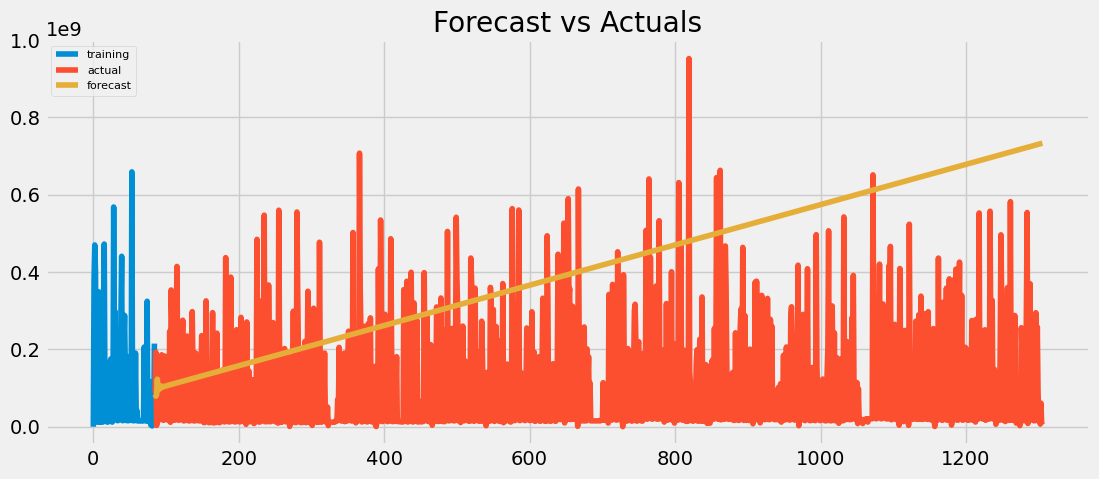

In [20]:
# Construimos un modelo
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  

# Pronosticamos nuestro modelo usando un intervalo de confianza del 95%
fc = fitted.forecast(steps=1221, alpha=0.05)  # 95% conf

# Creamos una serie de pandas
fc_series = pd.Series(fc, index=test.index)

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [21]:
 #Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           total_lineas   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1692.467
Date:                Sun, 05 Nov 2023   AIC                           3394.935
Time:                        21:41:14   BIC                           3407.029
Sample:                             0   HQIC                          3399.794
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6445      0.132     -4.881      0.000      -0.903      -0.386
ar.L2         -0.4524      0.181     -2.498      0.012      -0.807      -0.097
ar.L3         -0.2993      0.147     -2.037      0.0

En resumen, este modelo ARIMA(3, 2, 1) parece tener coeficientes significativos en las componentes AR y MA, lo que sugiere una relación con observaciones pasadas y errores pasados. Sin embargo, las pruebas de bondad de ajuste indican que los residuos no siguen una distribución normal y podrían haber problemas de heteroscedasticidad

# Métricas de Precisión para este modelo

In [22]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)  # ME
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mpe = np.mean((forecast - actual) / actual)  # MPE
    rmse = np.mean((forecast - actual)**2)**0.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlación
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]], axis=1))
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]], axis=1))
    minmax = 1 - np.mean(mins / maxs)  # Min-Max
    acf1 = acf(fc - test, fft=False)[1]  # ACF1
    # Imprimir las métricas
    print(f'MAPE: {mape}')
    print(f'ME: {me}')
    print(f'MAE: {mae}')
    print(f'MPE: {mpe}')
    print(f'RMSE: {rmse}')
    print(f'Correlación: {corr}')
    print(f'Min-Max: {minmax}')
    print(f'ACF1: {acf1}')
    
    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'acf1': acf1,
        'corr': corr,
        'minmax': minmax
    }


In [23]:
def forecast_accuracy(forecast, actual):
    forecast = forecast.to_numpy()  # Convertir forecast a matriz NumPy
    actual = actual.to_numpy()      # Convertir actual a matriz NumPy

    mae = np.mean(np.abs(forecast - actual))  # MAE
    rmse = np.mean((forecast - actual)**2)**0.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlación
    mins = np.amin(np.concatenate([forecast[:, None], actual[:, None]], axis=1))
    maxs = np.amax(np.concatenate([forecast[:, None], actual[:, None]], axis=1))
    minmax = 1 - np.mean(mins / maxs)  # Min-Max
    acf1 = acf(forecast - actual, fft=False)[1]  # ACF1

    # Imprimir los valores calculados
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Correlación:", corr)
    print("Min-Max:", minmax)
    print("ACF1:", acf1)

# Llamar a la función con forecast y actual como argumentos
forecast_accuracy(fc, test)




MAE: 323166642.5361489
RMSE: 376648130.4709866
Correlación: 0.027128582900527446
Min-Max: 0.9997466380259761
ACF1: 0.6868009612372744


**Conclusión:** Las métricas proporcionadas sugieren que este modelo no está funcionando de manera eficiente. El MAE y RMSE son muy altos, lo que indica una falta de precisión en las predicciones. La correlación es muy baja, lo que significa que las predicciones no se ajustan bien a los valores reales. Además, el coeficiente R^2 ajustado es cercano a 1, lo que podría ser un indicativo de sobreajuste del modelo a los datos de entrenamiento.

La alta autocorrelación de primer orden (ACF1) sugiere una posible dependencia temporal en los datos, pero esto no se traduce en un mejor rendimiento del modelo en términos de las métricas de evaluación. En general, se requiere una revisión y ajuste del modelo para mejorar su capacidad predictiva.

# Modelo SARIMA

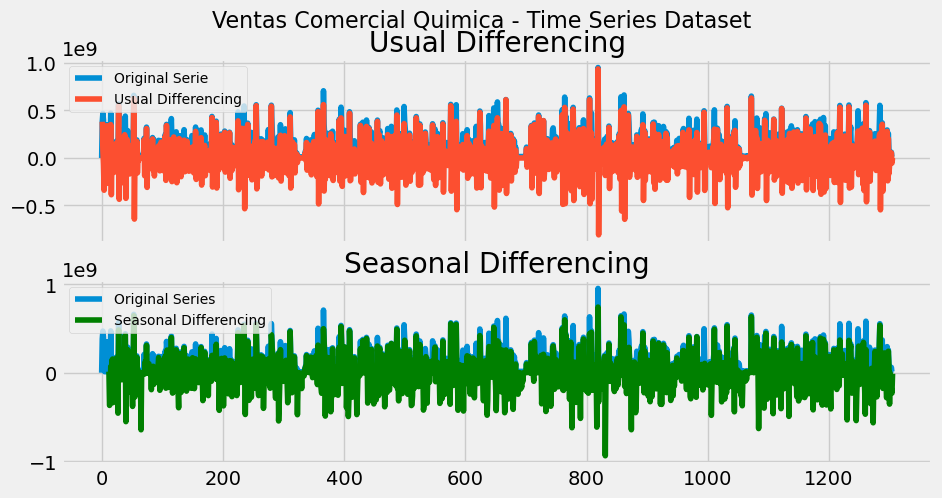

In [24]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(resultados['total_lineas'], label='Original Serie')
axes[0].plot(resultados['total_lineas'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(resultados['total_lineas'], label='Original Series')
axes[1].plot(resultados['total_lineas'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle('Ventas Comercial Quimica - Time Series Dataset', fontsize=16)
plt.show()


In [25]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(resultados.total_lineas, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=53060.909, Time=0.27 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=52724.014, Time=2.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=53059.006, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=53044.510, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=52565.457, Time=2.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=52580.851, Time=1.73 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=52553.828, Time=3.42 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=52708.105, Time=2.72 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.84 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1306
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -26266.908
Date:                            Sun, 05 Nov 2023   AIC                          52545.817
Time:                                    21:43:34   BIC                          52576.810
Sample:                                         0   HQIC                         52557.448
                                           - 1306                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1239      0.046      2.696      0.007       0.034       0.214
ar.L2         -0.0492      0.044     -1.107      0.268      -0.136       0.038
ar.L3         -0.0742      0.045     -1.635      0.102      -0.163       0.015
ar.S.L12      -0.6947      0.034    -20.376      0.000      -0.762      -0.628
ar.S.L24      -0.3870      0.034    -11.547      0.000      -0.453      -0.321
sigma2      3.592e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               355.21
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.91
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+49. Standard errors may be unstable.
"""

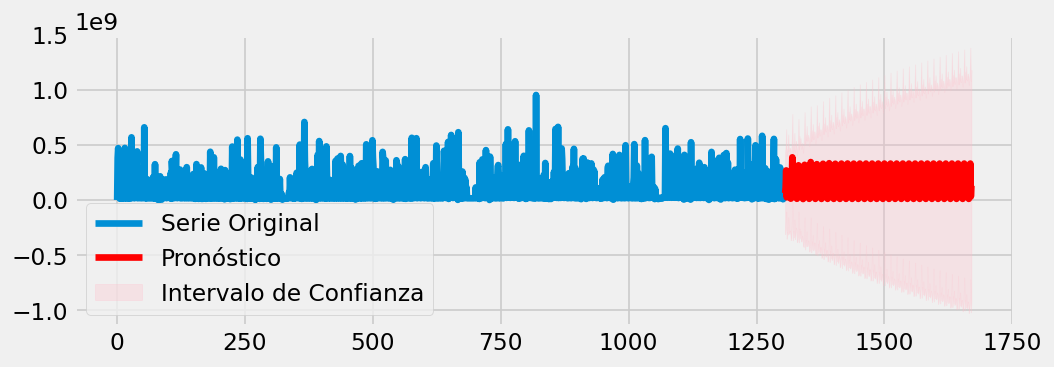

In [26]:
# Genera pronósticos
n_periods = 365  # Número de períodos a pronosticar
forecast, conf_int = smodel.predict(n_periods, return_conf_int=True)

# Gráfico de la serie original
plt.plot(resultados.total_lineas, label='Serie Original')

# Gráfico del pronóstico
plt.plot(range(len(resultados.total_lineas), len(resultados.total_lineas) + n_periods), forecast, label='Pronóstico', color='red')

# Gráfico de los intervalos de confianza
plt.fill_between(range(len(resultados.total_lineas), len(resultados.total_lineas) + n_periods), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza')

plt.legend()
plt.show()

In [27]:
# Configura el formato de los números en notación decimal normal
pd.options.display.float_format = '{:.2f}'.format

# Imprimir los valores pronosticados
print("Pronósticos:")
print(forecast)

Pronósticos:
1306    62605194.11
1307   114509663.07
1308   268208768.46
1309    24376394.47
1310    83804036.06
           ...     
1666    47294935.98
1667   115478323.75
1668   330328027.95
1669    31360645.73
1670   129306339.89
Length: 365, dtype: float64


# Modelo SARIMAX con variables Exógenas

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Especificar el período en función de la frecuencia de tus datos
period = 365  # Ejemplo: 12 para datos mensuales (si tus datos son mensuales)

# Calcular el índice estacional
result_add = seasonal_decompose(resultados['total_lineas'][-730:], model='additive', extrapolate_trend='freq', period=period)
seasonal_index = result_add.seasonal.to_frame()

# Agregar la columna 'month' a tu DataFrame 'resultados'
resultados['month'] = resultados['fecha_contabilizacion'].dt.month

# Combinar con los datos base utilizando el índice
resultados['seasonal_index'] = seasonal_index  # Agregar la columna 'seasonal_index'

# Seleccionar las columnas deseadas
resultados2 = resultados[['total_lineas', 'fecha_contabilizacion', 'seasonal_index']]

# Imprimir el nuevo DataFrame
print(resultados2)





      total_lineas fecha_contabilizacion  seasonal_index
0            10.00            2020-02-03             NaN
1     381204680.00            2020-02-04             NaN
2     470265000.00            2020-02-05             NaN
3     403212500.00            2020-02-06             NaN
4      63550000.00            2020-02-07             NaN
...            ...                   ...             ...
1301   15492143.15            2023-08-27    -97175132.73
1302    6960000.00            2023-08-28   -101436488.84
1303   61075000.00            2023-08-29    -51610177.37
1304    7300000.00            2023-08-30   -101087574.94
1305    4250000.00            2023-08-31   -102182455.38

[1306 rows x 3 columns]


In [29]:
# SARIMAX Model
sxmodel = pm.auto_arima(resultados2[['total_lineas']], exogenous=resultados2[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=53060.909, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=52724.014, Time=1.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=53059.006, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=53044.510, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=52565.457, Time=2.92 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=52580.851, Time=1.77 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=52553.828, Time=5.01 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=52708.105, Time=1.51 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1306
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -26266.908
Date:                            Sun, 05 Nov 2023   AIC                          52545.817
Time:                                    21:45:02   BIC                          52576.810
Sample:                                         0   HQIC                         52557.448
                                           - 1306                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1239      0.046      2.696      0.007       0.034       0.214
ar.L2         -0.0492      0.044     -1.107      0.268      -0.136       0.038
ar.L3         -0.0742      0.045     -1.635      0.102      -0.163       0.015
ar.S.L12      -0.6947      0.034    -20.376      0.000      -0.762      -0.628
ar.S.L24      -0.3870      0.034    -11.547      0.000      -0.453      -0.321
sigma2      3.592e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               355.21
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.91
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+49. Standard errors may be unstable.
"""

**Conclusión:** En resumen, los dos modelos proporcionan resultados prácticamente idénticos. Ambos tienen las mismas componentes AR y AR estacionales, con coeficientes similares. Los resultados de diagnóstico, incluidos los valores de Ljung-Box y Jarque-Bera, son los mismos en ambos casos. Esto sugiere que no hay diferencias sustanciales entre los dos modelos y que ambos son igualmente adecuados para ajustar los datos de series temporales proporcionados.

# MODELO ARMA

In [30]:
resultados_arma = resultados.drop('seasonal_index', axis=1)

In [31]:
resultados_arma

,fecha_contabilizacion,total_lineas,cantidad,month
0,2020-02-03,10.00,1,2
1,2020-02-04,381204680.00,83,2
2,2020-02-05,470265000.00,68,2
3,2020-02-06,403212500.00,99,2
4,2020-02-07,63550000.00,83,2
...,...,...,...,...
1301,2023-08-27,15492143.15,0,8
1302,2023-08-28,6960000.00,54,8
1303,2023-08-29,61075000.00,217,8
1304,2023-08-30,7300000.00,25,8


# Verificamos la estacionariedad con el Test de Dickey-Fuller

In [32]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Autoregressive Moving Average - ARMA(p,q)

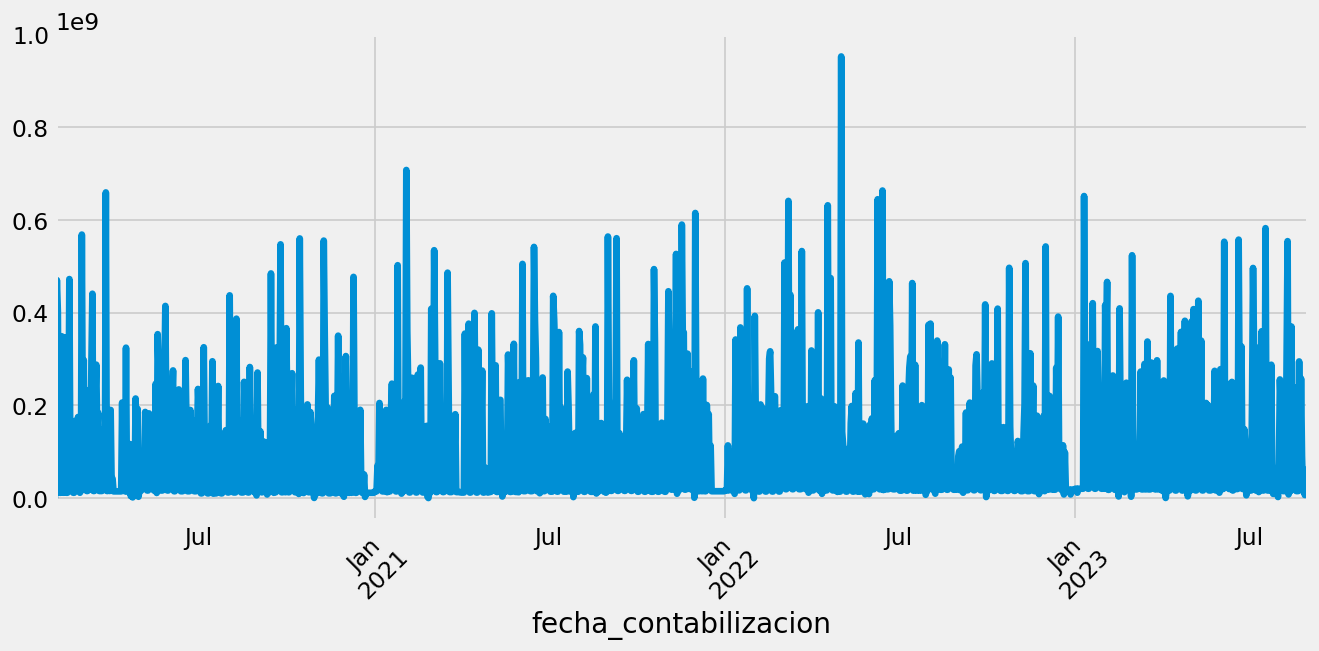

In [33]:
# Asegúrate de que 'fecha_contabilizacion' sea del tipo de datos datetime si no lo es ya
resultados['fecha_contabilizacion'] = pd.to_datetime(resultados['fecha_contabilizacion'])

# Filtra las fechas para comenzar desde febrero de 2020
resultados = resultados[resultados['fecha_contabilizacion'] >= '2020-02-01']

# Configura 'fecha_contabilizacion' como el índice
resultados.set_index('fecha_contabilizacion', inplace=True)

# Trazar 'total_lineas' con fechas en el eje x
resultados['total_lineas'].plot(figsize=(12, 5))

# Rotar las etiquetas para mayor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()



# Validamos la estacionariedad

In [34]:
adf_test(resultados_arma['total_lineas'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -7.68
p-value                   0.00
# lags used              22.00
# observations         1283.00
critical value (1%)      -3.44
critical value (5%)      -2.86
critical value (10%)     -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# Determinamos la orden de la serie (p,q) ARMA 

In [35]:
auto_arima(resultados_arma['total_lineas'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1306
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -26262.759
Date:                Sun, 05 Nov 2023   AIC                          52539.517
Time:                        21:45:07   BIC                          52575.740
Sample:                             0   HQIC                         52553.105
                               - 1306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.352e+08    5.2e-11    2.6e+18      0.000    1.35e+08    1.35e+08
ar.L1          0.1021      0.028      3.617      0.000       0.047       0.157
ar.L2         -0.0685      0.030     -2.290      0.022      -0.127      -0.010
ar.L3         -0.0887      0.028     -3.149      0.002      -0.144      -0.033
ar.L4         -0.0477      0.027     -1.800      0.072      -0.100       0.004
ar.L5         -0.0983      0.026     -3.788      0.000      -0.149      -0.047
sigma2      1.702e+16    4.3e-19   3.96e+34      0.000     1.7e+16     1.7e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1333.84
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.75
Prob(H) (two-sided):                  0.76   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+50. Standard errors may be unstable.
"""

In [36]:
# Dividimos los datos en entrenamiento y Test
train = resultados_arma.iloc[:1000]
test = resultados_arma.iloc[1000:]

# ARMA(p,q) Model

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar un modelo ARIMA
model = ARIMA(train['total_lineas'], order=(2, 0, 2))  # Aquí he usado un ejemplo de orden (p, d, q)
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:           total_lineas   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -20049.142
Date:                Sun, 05 Nov 2023   AIC                          40110.284
Time:                        21:45:08   BIC                          40139.730
Sample:                             0   HQIC                         40121.475
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.124e+08   1.62e-10   6.93e+17      0.000    1.12e+08    1.12e+08
ar.L1          1.2463      0.001   1592.924      0.000       1.245       1.248
ar.L2         -1.0000   5.89e-05   -1.7e+04      0.0

In [38]:
#Realizamos las predicciones correspondientes
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

# Graficamos los valores no Conocidos

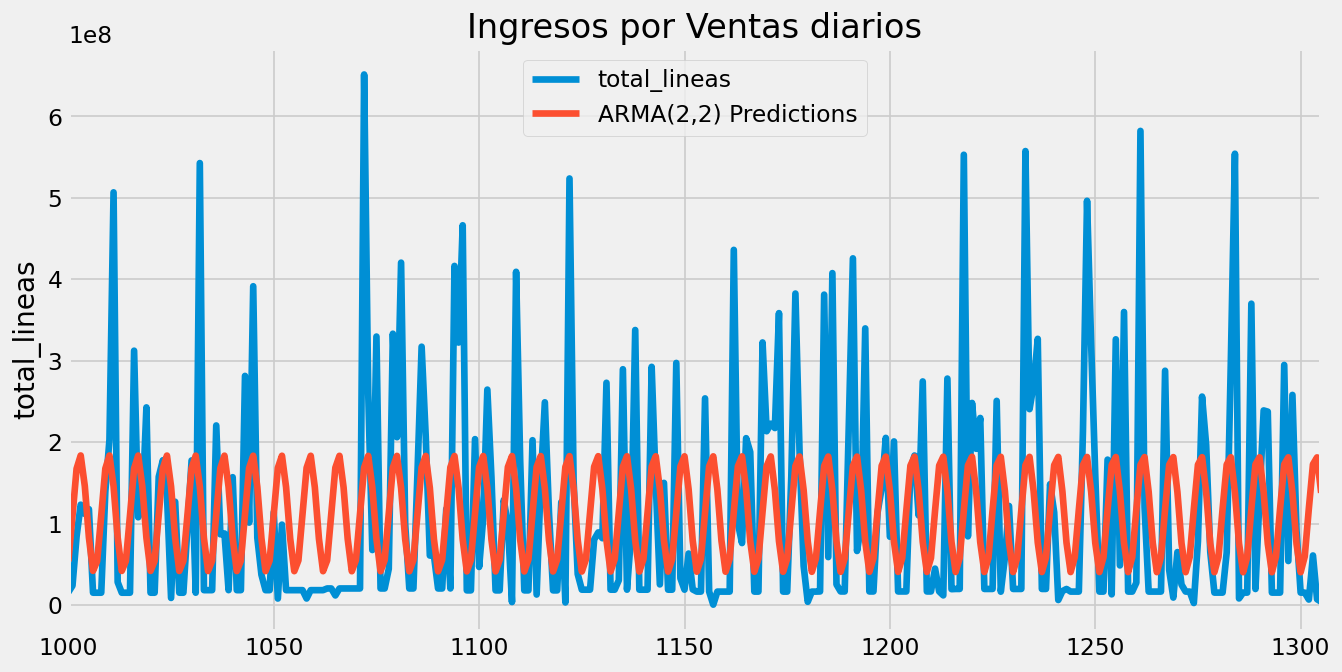

In [39]:
title = 'Ingresos por Ventas diarios'
ylabel='total_lineas'
xlabel='' # we don't really need a label here

ax = test['total_lineas'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Conclusiones:**
- El valor de Ljung-Box (Q) para el primer rezago es 1.09, lo que indica que no hay autocorrelación significativa en los residuos en el primer rezago.

- El valor de Jarque-Bera (JB) es 1748.20, lo que sugiere que los residuos no siguen una distribución normal. En este caso, el modelo puede no capturar completamente la estructura de la serie temporal.

- La prueba de heteroscedasticidad (H) indica que los residuos son heteroscedásticos (Prob(H) = 0.04).

- El modelo tiene un sesgo positivo (Skew = 1.92) y una alta curtosis (Kurtosis = 8.21) en los residuos, lo que sugiere que los residuos no siguen una distribución normal y tienen colas pesadas.

En resumen, el modelo ARMA(2, 0, 2) tiene coeficientes significativos tanto en las componentes AR como en las MA, pero los resultados de diagnóstico indican que los residuos no siguen una distribución normal y muestran heteroscedasticidad. Es posible que el modelo necesite una especificación diferente o que haya factores no considerados que afecten la serie temporal.

# Series de Tiempo Usando XGBoost

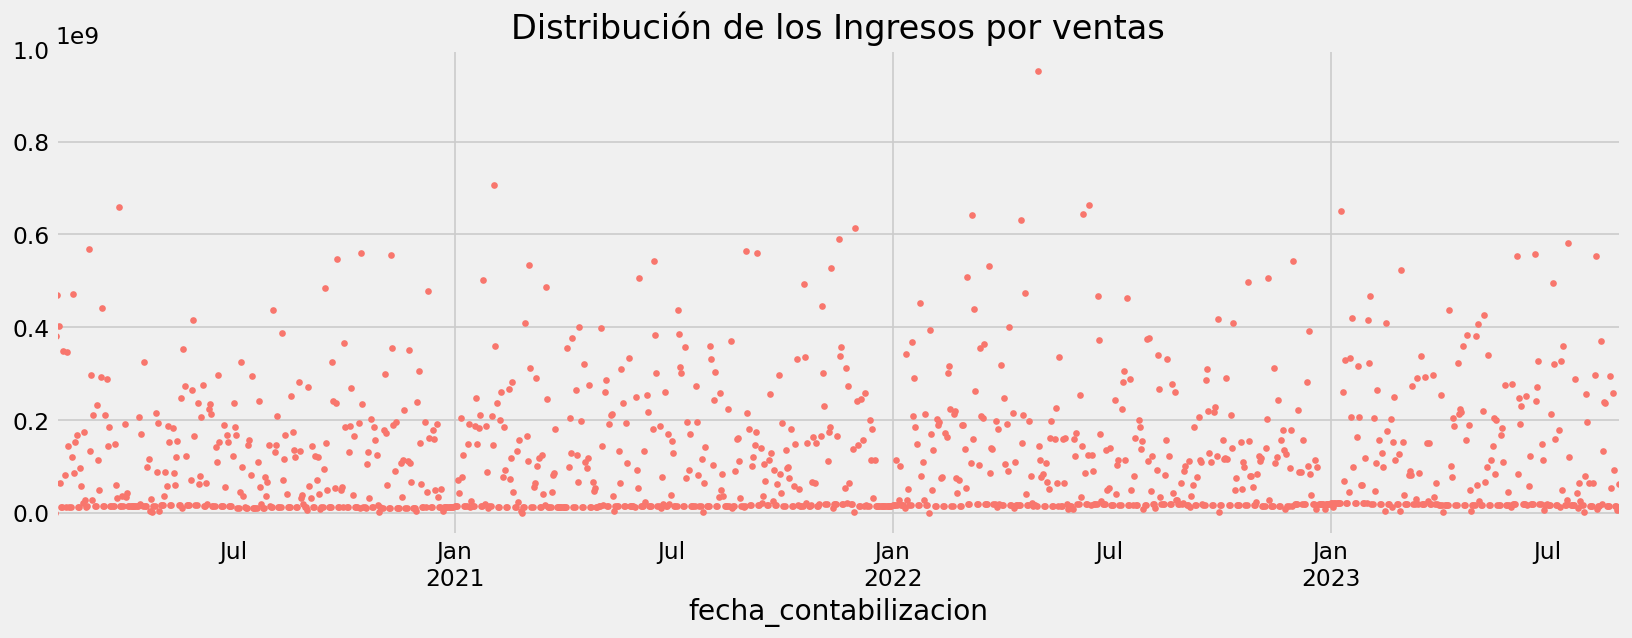

In [40]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
datos = resultados.total_lineas.plot(style='.', figsize=(15,5), color=color_pal[0], title='Distribución de los Ingresos por ventas')

In [41]:
#Dividimos nuestro dataset en entrenamiento y prueba
split_date = '2023-01-01'
pjme_train = resultados.loc[resultados.index <= split_date].copy()
pjme_test = resultados.loc[resultados.index > split_date].copy()

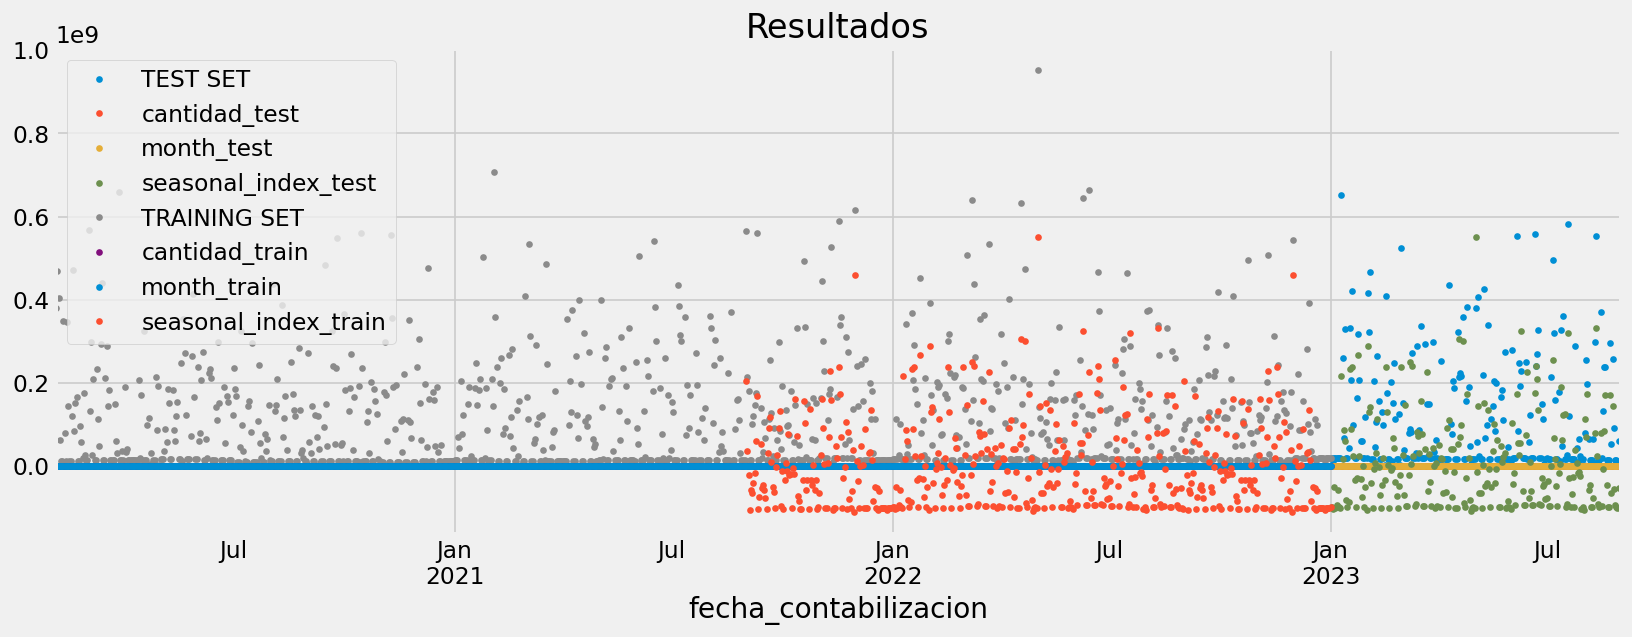

In [42]:
_ = pjme_test \
    .rename(columns={'total_lineas': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'total_lineas': 'TRAINING SET'}), how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15,5), title='Resultados', style='.')


In [43]:
#Creamos variables adicionales relacionadas con el tiempo
def create_features(resultados, label=None):
    """
    Creates time series features from datetime index
    """
    resultados['fecha_contabilizacion'] = resultados.index
    resultados['dayofweek'] = resultados['fecha_contabilizacion'].dt.dayofweek
    resultados['quarter'] = resultados['fecha_contabilizacion'].dt.quarter
    resultados['month'] = resultados['fecha_contabilizacion'].dt.month
    resultados['year'] = resultados['fecha_contabilizacion'].dt.year
    resultados['dayofyear'] = resultados['fecha_contabilizacion'].dt.dayofyear
    resultados['dayofmonth'] = resultados['fecha_contabilizacion'].dt.day
    resultados['weekofyear'] = resultados['fecha_contabilizacion'].dt.isocalendar().week
    
    X = resultados[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = resultados[label]
        return X, y
    return X



In [44]:
X_train, y_train = create_features(pjme_train, label='total_lineas')
X_test, y_test = create_features(pjme_test, label='total_lineas')

In [45]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

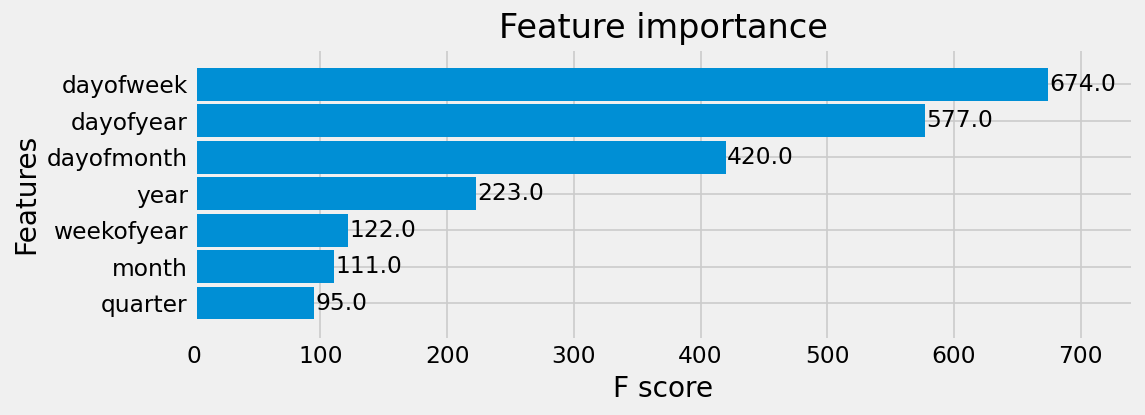

In [46]:
_ = plot_importance(reg, height=0.9)

In [47]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

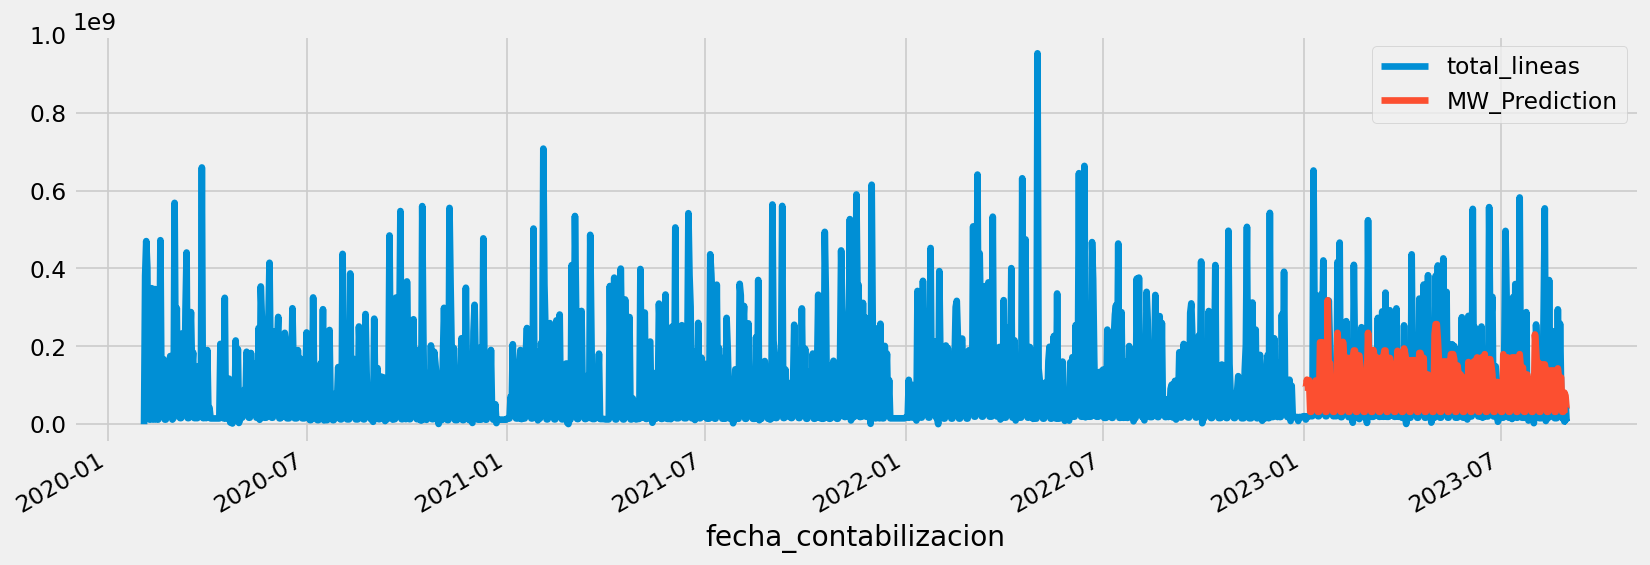

In [48]:
_ = pjme_all[['total_lineas','MW_Prediction']].plot(figsize=(15, 5))

# Validamos las métricas de error

In [49]:
mean_squared_error(y_true=pjme_test['total_lineas'],
                   y_pred=pjme_test['MW_Prediction'])

1.4242416806635096e+16

In [50]:
mean_absolute_error(y_true=pjme_test['total_lineas'],
                   y_pred=pjme_test['MW_Prediction'])

82843241.06332439

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
mean_absolute_percentage_error(y_true=pjme_test['total_lineas'],
                   y_pred=pjme_test['MW_Prediction'])

323.1314323793342

# Observamos los mejores y peores días predichos

In [53]:
pjme_test['error'] = pjme_test['total_lineas'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['fecha_contabilizacion','total_lineas','MW_Prediction','error','abs_error']]

In [54]:
# Peores días predichos
error_by_day.sort_values('error', ascending=True).head(10)

fecha_contabilizacion  total_lineas  MW_Prediction  \
year month dayofmonth                                                      
2023 5     1                     2023-05-01   16899552.13   230523168.00   
           3                     2023-05-03   59070000.00   257100208.00   
     3     6                     2023-03-06   19088646.84   190399936.00   
     2     15                    2023-02-15    3875000.00   170492032.00   
     1     16                    2023-01-16   44590000.00   210460048.00   
     4     4                     2023-04-04   16726497.52   181465872.00   
           5                     2023-04-05     700000.00   164306464.00   
     2     21                    2023-02-21   13138000.00   176409552.00   
     7     3                     2023-07-03   16744474.49   179694848.00   
           11                    2023-07-11   13357500.00   171529696.00   

                              error    abs_error  
year month dayofmonth                             
2023 5     1          -213623615.87 213623615.87  
           3          -198030208.00 198030208.00  
     3     6          -171311289.16 171311289.16  
     2     15         -166617032.00 166617032.00  
     1     16         -165870048.00 165870048.00  
     4     4          -164739374.48 164739374.48  
           5          -163606464.00 163606464.00  
     2     21         -163271552.00 163271552.00  
     7     3          -162950373.51 162950373.51  
           11         -158172196.00 158172196.00

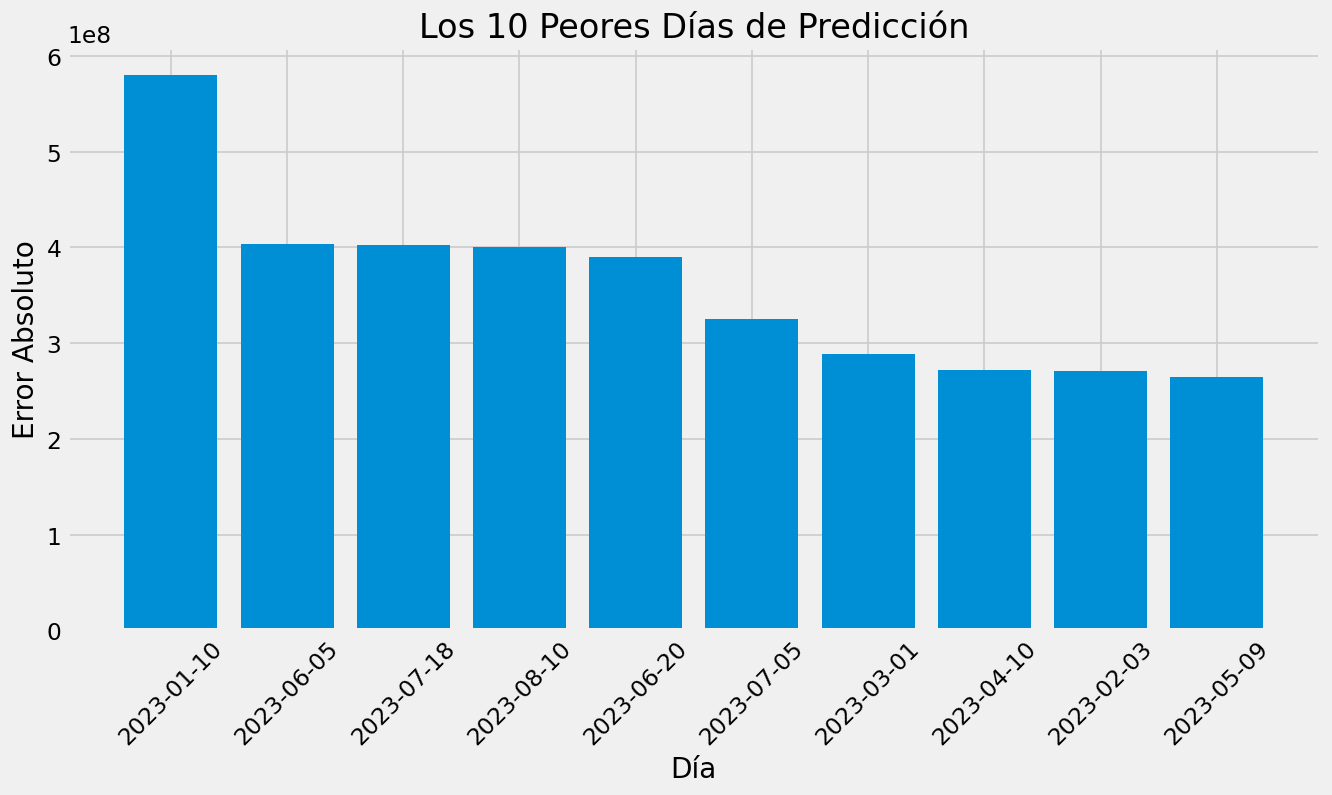

In [55]:
# Ordena los días por error absoluto en orden descendente
worst_days = error_by_day.sort_values('abs_error', ascending=False).head(10)

# Restablece el índice
worst_days = worst_days.reset_index()

# Gráfica los peores días de predicción
plt.figure(figsize=(12, 6))
plt.bar(worst_days.index, worst_days['abs_error'])
plt.xlabel('Día')
plt.ylabel('Error Absoluto')
plt.title('Los 10 Peores Días de Predicción')
plt.xticks(worst_days.index, worst_days['fecha_contabilizacion'].dt.date, rotation=45)
plt.show()





In [56]:
# Mejores días predichos
error_by_day.sort_values('abs_error', ascending=True).head(10)

fecha_contabilizacion  total_lineas  MW_Prediction  \
year month dayofmonth                                                      
2023 3     30                    2023-03-30   63462500.00    62112024.00   
           22                    2023-03-22  149510000.00   150886416.00   
     2     24                    2023-02-24  114265000.00   117121744.00   
     1     18                    2023-01-18  206225000.00   210460048.00   
     2     22                    2023-02-22  151600000.00   146690304.00   
     8     16                    2023-08-16  132755000.00   138042448.00   
     2     27                    2023-02-27  126625000.00   121239848.00   
     6     27                    2023-06-27  114000000.00   108346248.00   
     2     6                     2023-02-06  203925000.00   211556160.00   
     1     26                    2023-01-26   60995000.00    70930968.00   

                            error  abs_error  
year month dayofmonth                         
2023 3     30          1350476.00 1350476.00  
           22         -1376416.00 1376416.00  
     2     24         -2856744.00 2856744.00  
     1     18         -4235048.00 4235048.00  
     2     22          4909696.00 4909696.00  
     8     16         -5287448.00 5287448.00  
     2     27          5385152.00 5385152.00  
     6     27          5653752.00 5653752.00  
     2     6          -7631160.00 7631160.00  
     1     26         -9935968.00 9935968.00

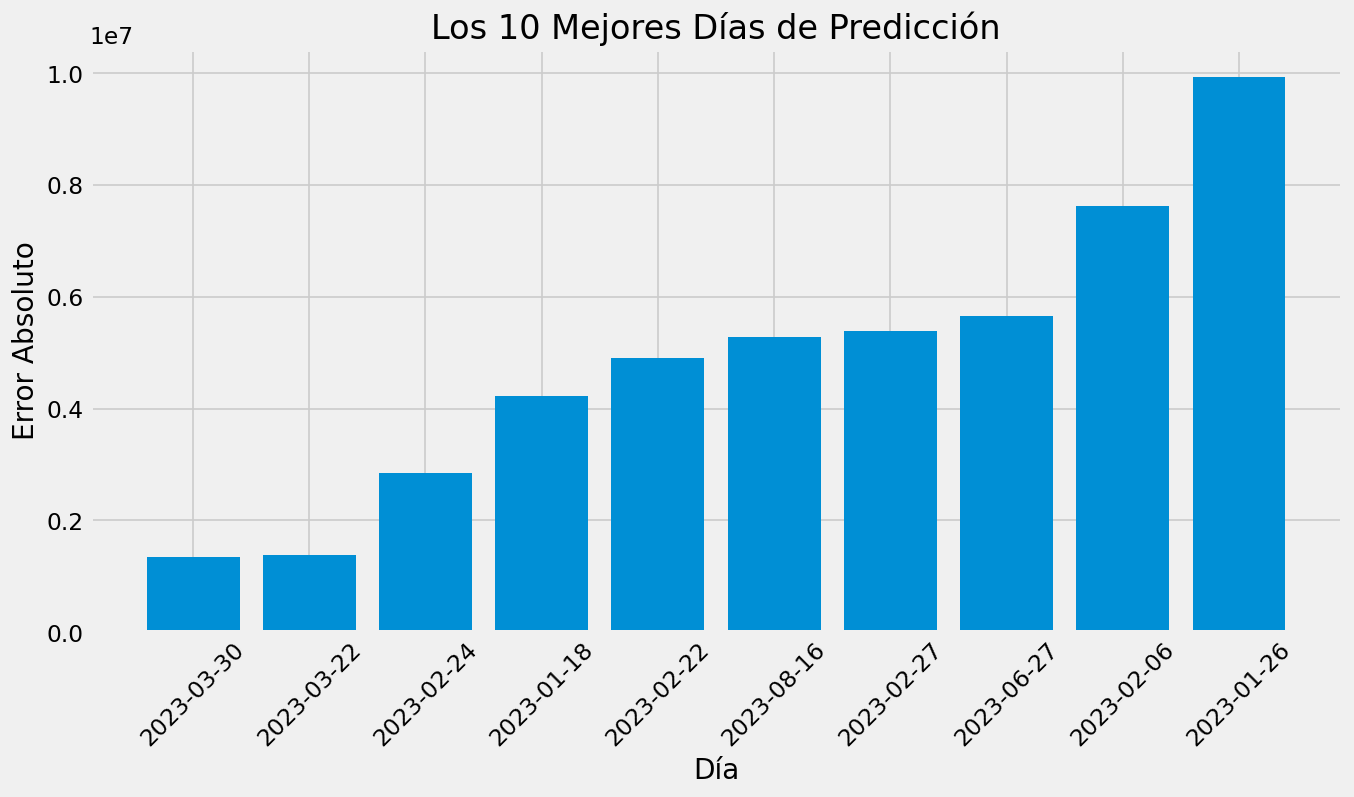

In [57]:
# Ordena los días por error absoluto en orden ascendente (los mejores)
best_days = error_by_day.sort_values('abs_error').head(10)

# Restablece el índice
best_days = best_days.reset_index()

# Gráfica los mejores días de predicción
plt.figure(figsize=(12, 6))
plt.bar(best_days.index, best_days['abs_error'])
plt.xlabel('Día')
plt.ylabel('Error Absoluto')
plt.title('Los 10 Mejores Días de Predicción')
plt.xticks(best_days.index, best_days['fecha_contabilizacion'].dt.date, rotation=45)
plt.show()


**Conclusión**:
- Podemos observar que un modelo XGboost es eficiente para la predicción de algunos días en especifico, sin embargo, este tipo de modelo no es óptimo para predecir el futuro a pesar de que sus metricas de error se ajustan de manera considerable

#  Modelos Prophet - LSTM

In [58]:
# Nos aseguramos que 'fecha_contabilizacion' sea del tipo datetime
data['fecha_contabilizacion'] = pd.to_datetime(data['fecha_contabilizacion'])

# Generamos un DataFrame con todas las fechas desde el mínimo al máximo
min_fecha = data['fecha_contabilizacion'].min()
max_fecha = data['fecha_contabilizacion'].max()
fechas_completas = pd.date_range(start=min_fecha, end=max_fecha, freq='D')

# Crear un nuevo DataFrame con todas las fechas y unirlo con los datos originales
nuevo_data = pd.DataFrame({'fecha_contabilizacion': fechas_completas})
nuevo_data = nuevo_data.merge(data, on='fecha_contabilizacion', how='left')

# Agrupar por mes y calcular la media
mes_media = nuevo_data.groupby(nuevo_data['fecha_contabilizacion'].dt.to_period('M'))['total_lineas'].transform('mean')

# Llenar los valores faltantes de 'total_lineas' con la media del mes correspondiente si no es NaN
nuevo_data['total_lineas'] = nuevo_data['total_lineas'].combine_first(mes_media)

# Agrupar por día y calcular la suma de 'total_lineas'
resultados = nuevo_data.groupby(['fecha_contabilizacion'])['total_lineas'].sum().reset_index()

# Llenar los valores no finitos de 'cantidad' con 0
nuevo_data['cantidad'] = nuevo_data['cantidad'].fillna(0)

# Agrupar por día y calcular el promedio de 'cantidad'
resultados['cantidad'] = nuevo_data.groupby(['fecha_contabilizacion'])['cantidad'].mean().reset_index()['cantidad']

# Redondear el promedio de 'cantidad' a números enteros
resultados['cantidad'] = resultados['cantidad'].round().astype(int)

print(resultados)

     fecha_contabilizacion  total_lineas  cantidad
0               2020-02-03         10.00         1
1               2020-02-04  381204680.00        83
2               2020-02-05  470265000.00        68
3               2020-02-06  403212500.00        99
4               2020-02-07   63550000.00        83
...                    ...           ...       ...
1301            2023-08-27   15492143.15         0
1302            2023-08-28    6960000.00        54
1303            2023-08-29   61075000.00       217
1304            2023-08-30    7300000.00        25
1305            2023-08-31    4250000.00        25

[1306 rows x 3 columns]


In [59]:
# Supongamos que tienes una columna 'fecha_contabilizacion' y una columna 'total_lineas'
resultados['ds'] = resultados['fecha_contabilizacion']
resultados['y'] = resultados['total_lineas']

# Asegúrate de que estas dos nuevas columnas están en el orden correcto
resultados = resultados[['ds', 'y']]


In [60]:
resultados

,ds,y
0,2020-02-03,10.00
1,2020-02-04,381204680.00
2,2020-02-05,470265000.00
3,2020-02-06,403212500.00
4,2020-02-07,63550000.00
...,...,...
1301,2023-08-27,15492143.15
1302,2023-08-28,6960000.00
1303,2023-08-29,61075000.00
1304,2023-08-30,7300000.00


21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


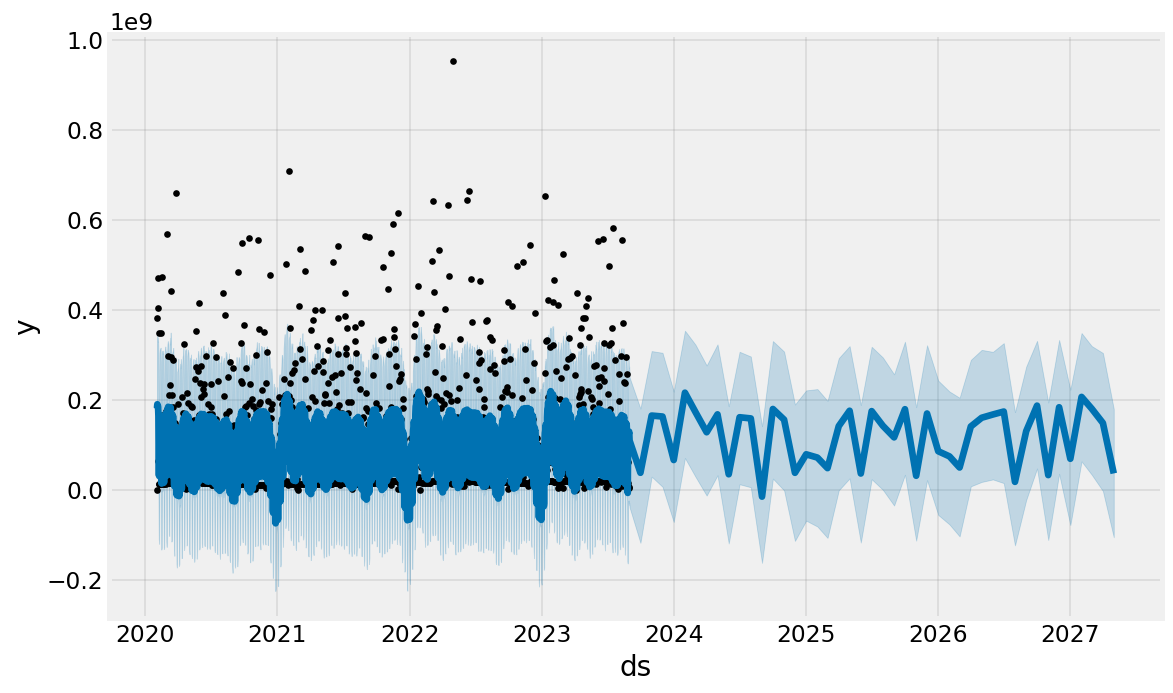

In [61]:
m = Prophet()
m.fit(resultados)
future = m.make_future_dataframe(45, freq = 'MS')
forecast = m.predict(future)
fig = m.plot(forecast)

# Cambiar la frecuencia a multiplicativa

21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


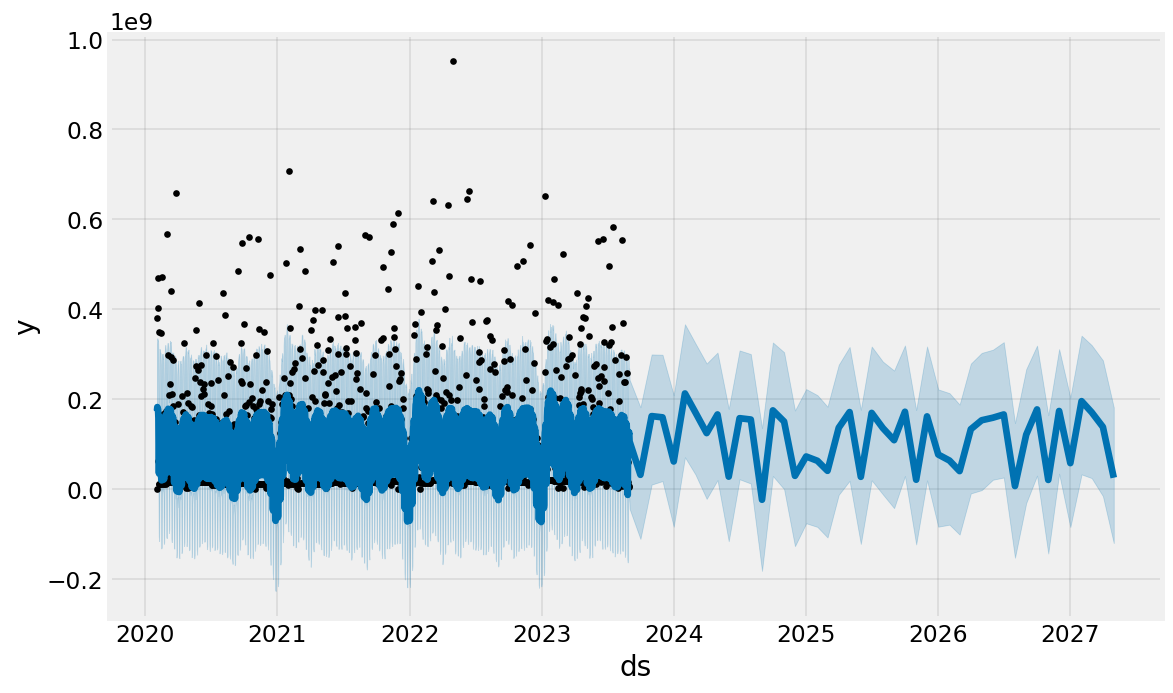

In [62]:
m = Prophet(seasonality_mode= 'multiplicative')
m.fit(resultados)
forecast = m.predict(future)
fig = m.plot(forecast)

In [63]:
pred_prophet = pd.DataFrame(forecast.yhat[-12:].values, index= forecast[-12:].ds.values)
pred_prophet.head()

,0
2026-06-01,159068509.37
2026-07-01,166303946.23
2026-08-01,7110768.28
2026-09-01,121204330.88
2026-10-01,177550003.66


**Conclusión:** El modelo Prophet ha demostrado ser eficiente en la generación de predicciones, siguiendo patrones de tendencia y estacionalidad que se ajustan razonablemente bien a los datos históricos disponibles. Sin embargo, es importante destacar que la eficiencia del modelo se ve limitada por la disponibilidad de datos. Dado que no se dispone de suficientes datos históricos para capturar todas las variaciones y tendencias potenciales en la serie temporal, las predicciones pueden carecer de precisión en la proyección a largo plazo. Por lo tanto, la calidad de las predicciones podría mejorarse con una mayor cantidad de datos históricos para alimentar el modelo

 # Red LSTM

In [64]:
# Nos aseguramos que 'fecha_contabilizacion' sea del tipo datetime
data['fecha_contabilizacion'] = pd.to_datetime(data['fecha_contabilizacion'])

# Generamos un DataFrame con todas las fechas desde el mínimo al máximo
min_fecha = data['fecha_contabilizacion'].min()
max_fecha = data['fecha_contabilizacion'].max()
fechas_completas = pd.date_range(start=min_fecha, end=max_fecha, freq='D')

# Crear un nuevo DataFrame con todas las fechas y unirlo con los datos originales
nuevo_data = pd.DataFrame({'fecha_contabilizacion': fechas_completas})
nuevo_data = nuevo_data.merge(data, on='fecha_contabilizacion', how='left')

# Agrupar por mes y calcular la media
mes_media = nuevo_data.groupby(nuevo_data['fecha_contabilizacion'].dt.to_period('M'))['total_lineas'].transform('mean')

# Llenar los valores faltantes de 'total_lineas' con la media del mes correspondiente si no es NaN
nuevo_data['total_lineas'] = nuevo_data['total_lineas'].combine_first(mes_media)

# Agrupar por día y calcular la suma de 'total_lineas'
resultados = nuevo_data.groupby(['fecha_contabilizacion'])['total_lineas'].sum().reset_index()

# Llenar los valores no finitos de 'cantidad' con 0
nuevo_data['cantidad'] = nuevo_data['cantidad'].fillna(0)

# Agrupar por día y calcular el promedio de 'cantidad'
resultados['cantidad'] = nuevo_data.groupby(['fecha_contabilizacion'])['cantidad'].mean().reset_index()['cantidad']

# Redondear el promedio de 'cantidad' a números enteros
resultados['cantidad'] = resultados['cantidad'].round().astype(int)

print(resultados)

     fecha_contabilizacion  total_lineas  cantidad
0               2020-02-03         10.00         1
1               2020-02-04  381204680.00        83
2               2020-02-05  470265000.00        68
3               2020-02-06  403212500.00        99
4               2020-02-07   63550000.00        83
...                    ...           ...       ...
1301            2023-08-27   15492143.15         0
1302            2023-08-28    6960000.00        54
1303            2023-08-29   61075000.00       217
1304            2023-08-30    7300000.00        25
1305            2023-08-31    4250000.00        25

[1306 rows x 3 columns]


In [65]:
# Define las fechas de inicio y fin para los conjuntos de entrenamiento y prueba
fecha_inicio_entrenamiento = '2020-01-01'
fecha_fin_entrenamiento = '2022-12-31'
fecha_inicio_prueba = '2023-01-01'

# Divide los datos en conjuntos de entrenamiento y prueba
train = resultados[(resultados['fecha_contabilizacion'] >= fecha_inicio_entrenamiento) & (resultados['fecha_contabilizacion'] <= fecha_fin_entrenamiento)]
test = resultados[resultados['fecha_contabilizacion'] >= fecha_inicio_prueba]

Para el entrenamiento de la Red LSTM usaremos los datos entre febrero de 2020 a agosto de 2022, mientras que para la validación y la predicción usaremos todos los registros del año 2023

**Normalización de los datos**


Para que la Red LSTM pueda ser entrenada se necesita que los valores de la serie se encuentran en un rango definido. Así que vamos a usar la librería Scikit-learn para normalizar estos valores en el rango de 0 a 1, usando la función MinMaxScaler.

Y una vez hecho el entrenamiento, al momento de la predicción, realizaremos la transformación inversa para obtener los valores en la escala real.

In [66]:
# Lista de columnas numéricas que deseas escalar
columnas_numericas = ['total_lineas']  # Agrega más columnas si es necesario

# Crea un MinMaxScaler
scaler = MinMaxScaler()

# Ajusta el escalador solo a los datos de entrenamiento
scaler.fit(train[columnas_numericas])

# Aplica el escalado a los datos de entrenamiento
train[columnas_numericas] = scaler.transform(train[columnas_numericas])

# Aplica el escalado a los datos de prueba
test[columnas_numericas] = scaler.transform(test[columnas_numericas])


Time Series Generator:
Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

In [67]:
# Escala los datos de entrenamiento
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[columnas_numericas])
scaled_test = scaler.fit_transform(test[columnas_numericas])

# Define el número de pasos de entrada
n_input = 12
n_features = 1

# Crea el generador de secuencias
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)



In [68]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [69]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.40021866 0.4937212  0.4233242  0.06671978 0.012478
 0.012478   0.36676461 0.08464242 0.012478   0.36447588 0.15093055]
Predict this y: 
 [[0.012478]]


**Creando el modelo**

In [70]:
# Como lo mencionamos anteriormente
# para crear la Red LSTM debemos primero crear un contenedor usando el módulo Sequential:
model = Sequential()
# Ahora añadimos la Red LSTM usando la función add, especificando el número de neuronas a usar 
# (parámetro units) y el tamaño de cada dato de entrada (parámetro input_shape):
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# Para la capa de salida usamos la función Dense y especificamos que el dato de salida 
# tendrá un tamaño igual a 1 (parámetro units):
model.add(Dense(1))
# Ahora debemos compilar el modelo, definiendo así la función de error (parámetro loss) 
# así como el método que se usará para minimizarla (parámetro optimizer):
model.compile(optimizer='adam', loss='mse')

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30
1051/1051 [==============================] - 5s 3ms/step - loss: 0.0195
Epoch 2/30
1051/1051 [==============================] - 4s 3ms/step - loss: 0.0193
Epoch 3/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0192
Epoch 4/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0191
Epoch 5/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0190
Epoch 6/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0189
Epoch 7/30
1051/1051 [==============================] - 4s 3ms/step - loss: 0.0187
Epoch 8/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0179
Epoch 9/30
1051/1051 [==============================] - 4s 3ms/step - loss: 0.0173
Epoch 10/30
1051/1051 [==============================] - 4s 3ms/step - loss: 0.0169
Epoch 11/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0168
Epoch 12/30
1051/1051 [==============================] - 3s 3ms/step - loss: 0.0166
E

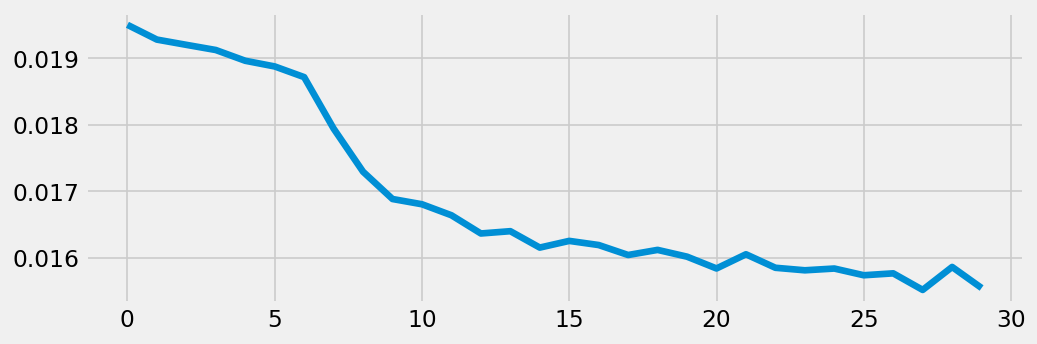

In [73]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [75]:
train_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(scaled_train)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    train_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 20ms/step


In [76]:
test_predictions

[array([0.07361016], dtype=float32),
 array([0.09183121], dtype=float32),
 array([0.07088827], dtype=float32),
 array([0.07091896], dtype=float32),
 array([0.07035859], dtype=float32),
 array([0.0509638], dtype=float32),
 array([0.05175349], dtype=float32),
 array([0.09353886], dtype=float32),
 array([0.10208593], dtype=float32),
 array([0.1091105], dtype=float32),
 array([0.11443795], dtype=float32),
 array([0.09620413], dtype=float32),
 array([0.04333971], dtype=float32),
 array([0.03858273], dtype=float32),
 array([0.11706467], dtype=float32),
 array([0.11164305], dtype=float32),
 array([0.12623903], dtype=float32),
 array([0.13465372], dtype=float32),
 array([0.10662822], dtype=float32),
 array([0.05349749], dtype=float32),
 array([0.02556976], dtype=float32),
 array([0.11354297], dtype=float32),
 array([0.14898977], dtype=float32),
 array([0.15318674], dtype=float32),
 array([0.14758424], dtype=float32),
 array([0.11611919], dtype=float32),
 array([0.05483332], dtype=float32),
 ar

In [77]:
scaled_test

array([[0.03054522],
       [0.03054522],
       [0.01736154],
       [0.03054522],
       [0.03054522],
       [0.03054522],
       [0.03054522],
       [0.03054522],
       [0.03054522],
       [1.        ],
       [0.39920014],
       [0.10301691],
       [0.50569167],
       [0.03054522],
       [0.03054522],
       [0.06743344],
       [0.51105146],
       [0.31577257],
       [0.64510251],
       [0.15217465],
       [0.03054522],
       [0.03054522],
       [0.25039025],
       [0.48655787],
       [0.317478  ],
       [0.0926384 ],
       [0.09241562],
       [0.03054522],
       [0.03054522],
       [0.18068291],
       [0.03054522],
       [0.638943  ],
       [0.49434229],
       [0.71557192],
       [0.02693139],
       [0.02693139],
       [0.31223881],
       [0.0710978 ],
       [0.16355183],
       [0.40561469],
       [0.23998869],
       [0.02693139],
       [0.02693139],
       [0.19735306],
       [0.15145253],
       [0.00487813],
       [0.62781933],
       [0.270

**Transformación inversa y comparación**

In [78]:
true_predictions = scaler.inverse_transform(test_predictions)

In [79]:
test['Predictions'] = true_predictions
test

,fecha_contabilizacion,total_lineas,cantidad,Predictions
1063,2023-01-01,0.02,0,0.05
1064,2023-01-02,0.02,0,0.06
1065,2023-01-03,0.01,75,0.05
1066,2023-01-04,0.02,0,0.05
1067,2023-01-05,0.02,0,0.05
...,...,...,...,...
1301,2023-08-27,0.02,0,0.01
1302,2023-08-28,0.01,54,0.07
1303,2023-08-29,0.06,217,0.11
1304,2023-08-30,0.01,25,0.11


In [80]:
true_predictions1 = scaler.inverse_transform(train_predictions)

In [81]:
train['Predictions'] = true_predictions1
train

,fecha_contabilizacion,total_lineas,cantidad,Predictions
0,2020-02-03,0.00,1,0.05
1,2020-02-04,0.40,83,0.06
2,2020-02-05,0.49,68,0.05
3,2020-02-06,0.42,99,0.05
4,2020-02-07,0.07,83,0.05
...,...,...,...,...
1058,2022-12-27,0.01,18,0.08
1059,2022-12-28,0.02,0,0.03
1060,2022-12-29,0.02,0,0.01
1061,2022-12-30,0.02,0,0.07


In [82]:
print("Dimensiones de scaled_train:", scaled_train.shape)
print("Dimensiones de train_predictions:", np.array(train_predictions).shape)


Dimensiones de scaled_train: (1063, 1)
Dimensiones de train_predictions: (1063, 1)


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = np.sqrt(mean_squared_error(scaled_train, train_predictions))
train_mae = mean_absolute_error(scaled_train, train_predictions)

print("RMSE de entrenamiento:", train_rmse)
print("MAE de entrenamiento:", train_mae)

RMSE de entrenamiento: 0.14879784785933692
MAE de entrenamiento: 0.11028619450284041


**Conclusión del Modelo:**
El modelo de red neuronal recurrente (LSTM) exhibe un error bajo en sus predicciones, lo que sugiere un buen rendimiento en la tarea de pronóstico. Sin embargo, es importante destacar que este modelo está entrenado en un conjunto de datos limitado y los datos disponibles pueden ser insuficientes para capturar todas las complejidades de la serie temporal. Como las redes neuronales, en particular las LSTM, son arquitecturas altamente adaptables y pueden aprender relaciones complejas en los datos, un conjunto de datos más grande podría permitir una modelización más precisa. Por lo tanto, aunque el modelo muestra un rendimiento prometedor, es esencial considerar la limitación de los datos y estar preparado para ajustar el modelo en el futuro si se dispone de más información.

# CONCLUSIONES PARCIALES

<table>
  <tr>
    <th>Modelo</th>
    <th>Conclusión</th>
  </tr>
  <tr>
    <td><strong>MODELOS ARIMA</strong></td>
    <td></td>
  </tr>
  <tr>
    <td>Modelo 1: ARIMA(1, 1, 2)</td>
    <td>El primer modelo, ARIMA(1, 1, 2), corresponde a un modelo ARIMA no estacional que se utiliza para modelar la parte no estacional de la serie de tiempo. En este modelo, se incluyen las componentes autorregresivas (AR), de diferenciación (I) y de media móvil (MA).</td>
  </tr>
  <tr>
    <td>Modelo 2: ARIMA(1, 1, 2)(1, 1, 2)[12]</td>
    <td>El segundo modelo, ARIMA(1, 1, 2)(1, 1, 2)[12], es un modelo ARIMA estacional que se utiliza para modelar la parte estacional de la serie de tiempo. Este modelo incluye los mismos componentes AR, I y MA, pero también agrega las componentes SAR (Autorregresión Estacional), SI (Diferenciación Estacional) y SMA (Media Móvil Estacional) para capturar la estacionalidad con un período de 12. Sin embargo, a pesar de la aplicación de estos modelos, los valores pronosticados no se ajustan de manera eficiente a los valores observados. Por lo tanto, es posible que sea necesario explorar otras alternativas de modelado para mejorar la precisión de las predicciones.</td>
  </tr>
  <tr>
    <td><strong>MODELO ARIMA con validación cruzada</strong></td>
    <td>Las métricas proporcionadas sugieren que este modelo no está funcionando de manera eficiente. El MAE y RMSE son muy altos, lo que indica una falta de precisión en las predicciones. La correlación es muy baja, lo que significa que las predicciones no se ajustan bien a los valores reales. Además, el coeficiente R^2 ajustado es cercano a 1, lo que podría ser un indicativo de sobreajuste del modelo a los datos de entrenamiento. La alta autocorrelación de primer orden (ACF1) sugiere una posible dependencia temporal en los datos, pero esto no se traduce en un mejor rendimiento del modelo en términos de las métricas de evaluación. En general, se requiere una revisión y ajuste del modelo para mejorar su capacidad predictiva.</td>
  </tr>
  <tr>
    <td><strong>MODELO SARIMA y SARIMA CON VARIABLES EXOGENAS</strong></td>
    <td>En resumen, los dos modelos proporcionan resultados prácticamente idénticos. Ambos tienen las mismas componentes AR y AR estacionales, con coeficientes similares. Los resultados de diagnóstico, incluidos los valores de Ljung-Box y Jarque-Bera, son los mismos en ambos casos. Esto sugiere que no hay diferencias sustanciales entre los dos modelos y que ambos son igualmente adecuados para ajustar los datos de series temporales proporcionados.</td>
  </tr>
  <tr>
    <td><strong>MODELO ARMA</strong></td>
    <td>El valor de Ljung-Box (Q) para el primer rezago es 1.09, lo que indica que no hay autocorrelación significativa en los residuos en el primer rezago. El valor de Jarque-Bera (JB) es 1748.20, lo que sugiere que los residuos no siguen una distribución normal. En este caso, el modelo puede no capturar completamente la estructura de la serie temporal. La prueba de heteroscedasticidad (H) indica que los residuos son heteroscedásticos (Prob(H) = 0.04). El modelo tiene un sesgo positivo (Skew = 1.92) y una alta curtosis (Kurtosis = 8.21) en los residuos, lo que sugiere que los residuos no siguen una distribución normal y tienen colas pesadas. En resumen, el modelo ARMA(2, 0, 2) tiene coeficientes significativos tanto en las componentes AR como en las MA, pero los resultados de diagnóstico indican que los residuos no siguen una distribución normal y muestran heteroscedasticidad. Es posible que el modelo necesite una especificación diferente o que haya factores no considerados que afecten la serie temporal.</td>
  </tr>
  <tr>
    <td><strong>SERIE TEMPORAL XGBOOST</strong></td>
    <td>Podemos observar que un modelo XGboost es eficiente para la predicción de algunos días en específico, sin embargo, este tipo de modelo no es óptimo para predecir el futuro a pesar de que sus métricas de error se ajustan de manera considerable.</td>
  </tr>
  <tr>
    <td><strong>MODELO PROPHET</strong></td>
    <td>Conclusión: El modelo Prophet ha demostrado ser eficiente en la generación de predicciones, siguiendo patrones de tendencia y estacionalidad que se ajustan razonablemente bien a los datos históricos disponibles. Sin embargo, es importante destacar que la eficiencia del modelo se ve limitada por la disponibilidad de datos. Dado que no se dispone de suficientes datos históricos para capturar todas las variaciones y tendencias potenciales en la serie temporal, las predicciones pueden carecer de precisión en la proyección a largo plazo. Por lo tanto, la calidad de las predicciones podría mejorarse con una mayor cantidad de datos históricos para alimentar el modelo.</td>
  </tr>
  <tr>
    <td><strong>MODELO LSTM</strong></td>
    <td>Conclusión del Modelo: El modelo de red neuronal recurrente (LSTM) exhibe un error bajo en sus predicciones, lo que sugiere un buen rendimiento en la tarea de pronóstico. Sin embargo, es importante destacar que este modelo está entrenado en un conjunto de datos limitado y los datos disponibles pueden ser insuficientes para capturar todas las complejidades de la serie temporal. Como las redes neuronales, en particular las LSTM, son arquitecturas altamente adaptables y pueden aprender relaciones complejas en los datos, un conjunto de datos más grande podría permitir una modelización más precisa. Por lo tanto, aunque el modelo muestra un rendimiento prometedor, es esencial considerar la limitación de los datos y estar preparado para ajustar el modelo en el futuro si se dispone de más información.</td>
  </tr>
</table>
